# Livrable 3 – Image Captioning

**Objectif :** Construire un modèle CNN–RNN avec attention pour générer des légendes sur MS COCO.

Le réseau est composé de :
- Un **encodeur CNN** (InceptionV3 pré‑entraîné) qui transforme l’image en représentations visuelles,
- Un **décodeur RNN** (GRU + Attention) qui génère la légende mot à mot.

#  Importation des bibliothèques et définition des constantes
On commence par importer les bibliothèques nécessaires et définir les constantes globales pour l'entraînement et les chemins d'accès à MS COCO

(On a choisi 64 en Batch Size)

In [3]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import os, json, collections
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


BASE_DIR       = "../"
COCO_DIR       = os.path.join(BASE_DIR, 'datasets', 'coco')
ANN_DIR        = os.path.join(COCO_DIR, 'annotations')
IMG_TRAIN_DIR  = os.path.join(COCO_DIR, 'images', 'train2014')
IMG_VAL_DIR    = os.path.join(COCO_DIR, 'images', 'val2014')

BATCH_SIZE   = 64
BUFFER_SIZE  = 1000
EMBED_DIM    = 256
UNITS        = 512
VOCAB_SIZE   = 5000
MAX_LENGTH   = 50
EPOCHS       = 20
FEATURE_SHAPE = 64

# Chargement des annotations et préparation des chemins d'images
On charge les fichiers JSON d’annotations du dataset COCO, et on réalise le regroupement des légendes par image

In [4]:
with open(os.path.join(ANN_DIR, 'captions_train2014.json'), 'r') as f:
    ann = json.load(f)

# image_id → nom de fichier
id2file = {img['id']: img['file_name'] for img in ann['images']}

# Regrouper les captions par chemin complet
cap_dict = collections.defaultdict(list)
for a in ann['annotations']:
    fname = id2file[a['image_id']]
    path  = os.path.join(IMG_TRAIN_DIR, fname)
    cap   = '<start> ' + a['caption'].lower().strip() + ' <end>'
    cap_dict[path].append(cap)

# Listes finales
all_image_paths = list(cap_dict.keys())
all_captions    = [c for caps in cap_dict.values() for c in caps]

print(f"{len(all_image_paths)} images, {len(all_captions)} captions")

82783 images, 414113 captions


# Réduction du dataset pour un entraînement plus rapide
Réduction volontaire du nombre d’images à 10 000 pour limiter les besoins en GPU et accélérer l'entraînement.

In [5]:
# Cellule 2 bis - à effacer si vous voulez lancer l'entrainement avec toute les images (j'espère que vous avez un bon GPU si vous le faite)

# on ne prend que 10 000 images car pas assez de GPUUUUUUUUUUUU on a des MAAAAC !!
selected_image_paths = all_image_paths[:10000]

# On recrée cap_dict uniquement pour ces images
cap_dict = {path: cap_dict[path] for path in selected_image_paths}

# mise à jour all_image_paths et all_captions 
all_image_paths = selected_image_paths
all_captions    = [c for caps in cap_dict.values() for c in caps]

print("Nombre d'images pour le test :", len(all_image_paths))
print("Nombre de captions associées :", len(all_captions))

Nombre d'images pour le test : 10000
Nombre de captions associées : 50020


In [6]:
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token='<unk>',
    filters='!"#$%&()*+.,-/:;?@[\]^_`{|}~ '
)
tokenizer.fit_on_texts(all_captions)

# reservation de l'indice 0 pour <pad>
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0]   = '<pad>'

# Conversion des légendes en séquences d'indices et padding
cap_seqs = tokenizer.texts_to_sequences(all_captions)
cap_seqs = pad_sequences(cap_seqs, maxlen=MAX_LENGTH, padding='post')

print("Exemple :", all_captions[0], "→", cap_seqs[0])

Exemple : <start> a very clean and well decorated empty bathroom <end> → [  3   2  85 121   7 385 270 157  11   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Extraction des caractéristiques visuelles avec InceptionV3
On utilise ici un CNN pré-entraîné (InceptionV3) pour extraire les caractéristiques visuelles des images et les sauvegarder au format `.npy`.


In [ ]:
# Chargement d'InceptionV3 
image_model = InceptionV3(include_top=False, weights='imagenet')
new_input = tf.keras.Input(shape=(299, 299, 3))
hidden_layer = image_model(new_input)  # sortie : (batch, 8, 8, 2048)
feat_extract_model = Model(inputs=new_input, outputs=hidden_layer)

# Fonction de chargement et pré‑traitement d'une image
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, path

# Création du dataset d'images pré‑traitées
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = image_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_ds = image_ds.batch(BATCH_SIZE)

# Extraction et sauvegarde des représentations
for img_batch, path_batch in tqdm(image_ds):
    # Extraction features : (bs, 8,8,2048) → reshape (bs, 64, 2048)
    batch_features = feat_extract_model(img_batch)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    # Sauvegarde .npy pour chaque image
    for bf, p in zip(batch_features, path_batch.numpy()):
        np.save(p.decode('utf-8'), bf.numpy())

# Création du dataset TensorFlow pour l’entraînement
On Prépare le dataset combinant les vecteurs d’images et les légendes qui correspondent aux images


In [8]:
def map_func(img_path, cap):
    img_tensor = np.load(img_path.decode('utf-8') + '.npy')
    return img_tensor, cap

# Construction listes de chemins et séquences de captions
img_name_vector = []
cap_vector      = []

for img_path, caps in cap_dict.items():
    img_name_vector.extend([img_path] * len(caps))
    cap_vector.extend(caps)

# Conversion les captions en séquences et appliquer le padding
cap_seqs = tokenizer.texts_to_sequences(cap_vector)
cap_seqs = pad_sequences(cap_seqs, maxlen=MAX_LENGTH, padding='post')

# Création et optimisation du tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_seqs))
dataset = dataset.map(
    lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print("Dataset prêt :", dataset)

Dataset prêt : <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>


# Définition du modèle : Encodeur CNN, Attention Bahdanau et Décodeur RNN
Implémentation des différentes composantes du modèle : l’encodeur extrait les features, l’attention pondère ces features, et le décodeur génère les mots de la légende.

In [10]:
# Instanciation de l'encodeur
class CNN_Encoder(Model):
    def __init__(self, embed_dim):
        super().__init__()
        self.fc = Dense(embed_dim)
    def call(self, x):
        return tf.nn.relu(self.fc(x)) 

# Instanciation de l'attention Bahdanau
class BahdanauAttention(Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)                      # (batch,1,units)
        score       = tf.nn.tanh(self.W1(features) + self.W2(hidden_time))
        weights     = tf.nn.softmax(self.V(score), axis=1)           # (batch,64,1)
        context     = tf.reduce_sum(weights * features, axis=1)      # (batch,units)
        return context, weights

# Instanciation du décodeur
class RNN_Decoder(Model):
    def __init__(self, vocab_size, embed_dim, units):
        super().__init__()
        self.units     = units
        self.embedding = Embedding(vocab_size, embed_dim)
        self.gru       = GRU(units,
                             return_sequences=True,
                             return_state=True,
                             recurrent_initializer='glorot_uniform',
                             unroll=True)
        self.fc1       = Dense(units)
        self.fc2       = Dense(vocab_size)
        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):
        # calcul de l'attention
        context, att_w = self.attention(features, hidden)            # (batch,units) 
        x = self.embedding(x)                                        # (batch,1,embed_dim)
        x = tf.concat([tf.expand_dims(context,1), x], axis=-1)       # (batch,1,embed_dim+units)
        output, state = self.gru(x, initial_state=hidden)            # (batch,1,units), (batch,units)
        x = self.fc1(output)                                         # (batch,1,units)
        x = tf.reshape(x, (-1, x.shape[2]))                          # (batch,units)
        x = self.fc2(x)                                              # (batch,vocab_size)
        return x, state, att_w

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# (Re)instanciation
encoder     = CNN_Encoder(EMBED_DIM)
decoder     = RNN_Decoder(VOCAB_SIZE, EMBED_DIM, UNITS)
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_ * tf.cast(mask, loss_.dtype))

# Entraînement du modèle
Boucle d'entraînement sur 20 époques, avec calcul de la loss et mise à jour des poids à chaque batch

In [ ]:
def train_step(img_tensor, target):
    loss = 0.0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    # initialisation du token <start>
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], axis=1
    )
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)  # (batch, 64, embed_dim)
        for i in range(1, target.shape[1]):
            # on passe training=True pour la GRU
            predictions, hidden, _ = decoder(dec_input, features, hidden, training=True)
            loss += loss_function(target[:, i], predictions)
            # teacher forcing
            dec_input = tf.expand_dims(target[:, i], axis=1)
    total_loss = loss / int(target.shape[1])
    # gradients et optimisation
    train_vars = encoder.trainable_variables + decoder.trainable_variables
    grads      = tape.gradient(loss, train_vars)
    optimizer.apply_gradients(zip(grads, train_vars))
    return total_loss


loss_history = [] 

for epoch in range(EPOCHS):
    total_loss = 0.0
    for img_tensor, target in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_loss = train_step(img_tensor, target)
        total_loss += batch_loss
    epoch_loss = total_loss / dataset.cardinality().numpy()
    loss_history.append(epoch_loss) 
    print(f"→ Epoch {epoch+1}/{EPOCHS}, Loss moyenne : {epoch_loss:.4f}")

Epoch 1/20: 100%|██████████| 782/782 [14:34<00:00,  1.12s/it]


Epoch 1, Loss moyenne : 0.8059


Epoch 2/20: 100%|██████████| 782/782 [14:18<00:00,  1.10s/it]


Epoch 2, Loss moyenne : 0.6308


Epoch 3/20: 100%|██████████| 782/782 [39:24<00:00,  3.02s/it]


Epoch 3, Loss moyenne : 0.5679


Epoch 4/20: 100%|██████████| 782/782 [40:54<00:00,  3.14s/it]


Epoch 4, Loss moyenne : 0.5233


Epoch 5/20: 100%|██████████| 782/782 [13:52<00:00,  1.06s/it]


Epoch 5, Loss moyenne : 0.4836


Epoch 6/20: 100%|██████████| 782/782 [13:35<00:00,  1.04s/it]


Epoch 6, Loss moyenne : 0.4454


Epoch 7/20: 100%|██████████| 782/782 [13:43<00:00,  1.05s/it]


Epoch 7, Loss moyenne : 0.4089


Epoch 8/20: 100%|██████████| 782/782 [13:27<00:00,  1.03s/it]


Epoch 8, Loss moyenne : 0.3750


Epoch 9/20: 100%|██████████| 782/782 [13:59<00:00,  1.07s/it]


Epoch 9, Loss moyenne : 0.3437


Epoch 10/20: 100%|██████████| 782/782 [13:56<00:00,  1.07s/it]


Epoch 10, Loss moyenne : 0.3148


Epoch 11/20: 100%|██████████| 782/782 [13:58<00:00,  1.07s/it]


Epoch 11, Loss moyenne : 0.2897


Epoch 12/20: 100%|██████████| 782/782 [14:16<00:00,  1.09s/it]


Epoch 12, Loss moyenne : 0.2673


Epoch 13/20: 100%|██████████| 782/782 [13:56<00:00,  1.07s/it]


Epoch 13, Loss moyenne : 0.2490


Epoch 14/20: 100%|██████████| 782/782 [14:00<00:00,  1.07s/it]


Epoch 14, Loss moyenne : 0.2329


Epoch 15/20: 100%|██████████| 782/782 [14:15<00:00,  1.09s/it]


Epoch 15, Loss moyenne : 0.2191


Epoch 16/20: 100%|██████████| 782/782 [13:23<00:00,  1.03s/it]


Epoch 16, Loss moyenne : 0.2073


Epoch 17/20: 100%|██████████| 782/782 [13:44<00:00,  1.05s/it]


Epoch 17, Loss moyenne : 0.1971


Epoch 18/20: 100%|██████████| 782/782 [34:09<00:00,  2.62s/it]


Epoch 18, Loss moyenne : 0.1880


Epoch 19/20: 100%|██████████| 782/782 [14:31<00:00,  1.11s/it]


Epoch 19, Loss moyenne : 0.1805


Epoch 20/20: 100%|██████████| 782/782 [15:25<00:00,  1.18s/it]

Epoch 20, Loss moyenne : 0.1743


# Visualisation de la courbe de perte
Maintenant que l'entraintement a été effectué, on affiche de l’évolution de la loss moyenne par époque

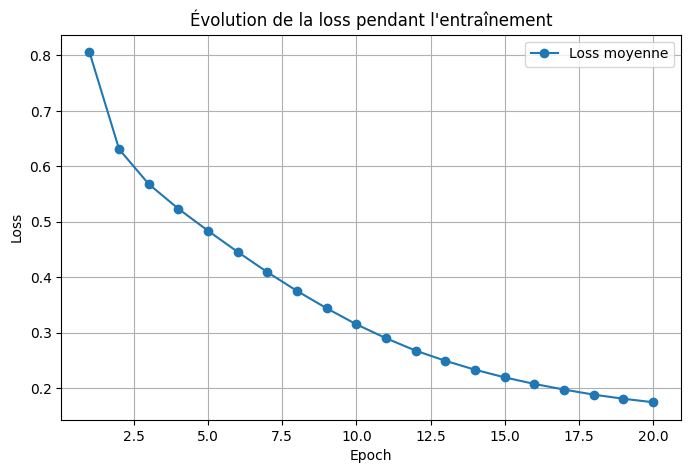

In [ ]:
epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_history, marker='o', label='Loss moyenne')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss pendant l'entraînement")
plt.grid(True)
plt.legend()
plt.show()

# Sauvegarde des modèles et du tokenizer
On exporte les modèles encodeur/décodeur au format `.keras` et on exporte aussi le tokenizer au format pickle

In [ ]:
# 1) Sauvegarde de l’encodeur avec architecture + poids
encoder.save('encoder_model.keras', save_format='keras')
print("✅ Encodeur exporté : encoder_model.keras")

# 2) Sauvegarde du décodeur avec architecture + poids
decoder.save('decoder_model.keras', save_format='keras')
print("✅ Décodeur exporté : decoder_model.keras")

# 3) On garde le tokenizer en pickle
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer enregistré : tokenizer.pkl")

✅ Encodeur exporté : encoder_model.keras
✅ Décodeur exporté : decoder_model.keras
✅ Tokenizer enregistré : tokenizer.pkl


# Génération des légendes sur des images de validation
On fait une évaluation du modèle en générant des légendes sur un échantillon d’images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

# Sélection de quelques images de validation
val_image_paths = glob(os.path.join(IMG_VAL_DIR, '*.jpg'))[:35]

def evaluate(image_path):
    # Pré‑traitement
    img, _ = load_image(image_path)
    img = tf.expand_dims(img, 0)
    # Extraction des features
    features = feat_extract_model(img)                                  # (1,8,8,2048)
    features = tf.reshape(features, (1, -1, features.shape[3]))       # (1,64,2048)
    features = encoder(features)                                       # (1,64,embed_dim)
    # Décodage séquentiel
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(MAX_LENGTH):
        predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)
        predicted_id = tf.argmax(predictions[0]).numpy()
        word = tokenizer.index_word.get(predicted_id, '<unk>')
        if word == '<end>':
            break
        result.append(word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)

# Affichage des images et des légendes générées
for img_path in val_image_paths:
    plt.figure(figsize=(5,5))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    print("Prédiction :", evaluate(img_path))
    plt.show()

# Évaluation du modèle avec BLEU-4 et ROUGE
On fait le calcul des scores BLEU-4 et ROUGE sur 100 images de validation pour quantifier les performances du modèle sur la génération des captions.

In [ ]:
# Chargement des annotations de validation
with open(os.path.join(ANN_DIR, 'captions_val2014.json'), 'r') as f:
    ann_val = json.load(f)
id2file_val = {img['id']: img['file_name'] for img in ann_val['images']}

val_cap_dict = collections.defaultdict(list)
for a in ann_val['annotations']:
    fname = id2file_val[a['image_id']]
    path  = os.path.join(IMG_VAL_DIR, fname)
    # tokeniser chaque référence (sans <start>/<end>)
    val_cap_dict[path].append(a['caption'].lower().strip().split())

# Préparation des références et hypothèses
references = []
hypotheses = []
for img_path, refs in list(val_cap_dict.items())[:100]:  # limiter à 100 images
    references.append(refs)
    hypotheses.append(evaluate(img_path).split())

# Indicateurs de performance

# Calcul BLEU-4
bleu4 = corpus_bleu(references, hypotheses)
print(f"BLEU-4 = {bleu4:.4f}")

# 4) Calcul ROUGE-1 et ROUGE-L
scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
rouge1_scores = []
rougeL_scores = []
for refs, hyp in zip(references, hypotheses):
    ref_sent = ' '.join(refs[0])
    hyp_sent = ' '.join(hyp)
    scores = scorer.score(ref_sent, hyp_sent)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1 = {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-L = {np.mean(rougeL_scores):.4f}")